In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
!pip install sqlalchemy

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 1.4 MB/s eta 0:00:02
   ---------- ----------------------------- 0.6/2.1 MB 8.9 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.1 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 16.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/293.6 kB ? eta -:--:--
   ---------------------------------------- 293.6/293.6 kB ? eta 0:00:00


In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base= automap_base()
# reflect the tables
base.prepare(engine, reflect= True)

C:\Users\Sarah\AppData\Local\Temp\ipykernel_6620\1750415282.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect= True)


In [17]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
measurement= base.classes.measurement
station= base.classes.station

In [19]:
# Create our session (link) from Python to the DB
inspector = inspect(engine)

In [20]:
columns= inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [21]:
session= Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.


('2017-08-23',)

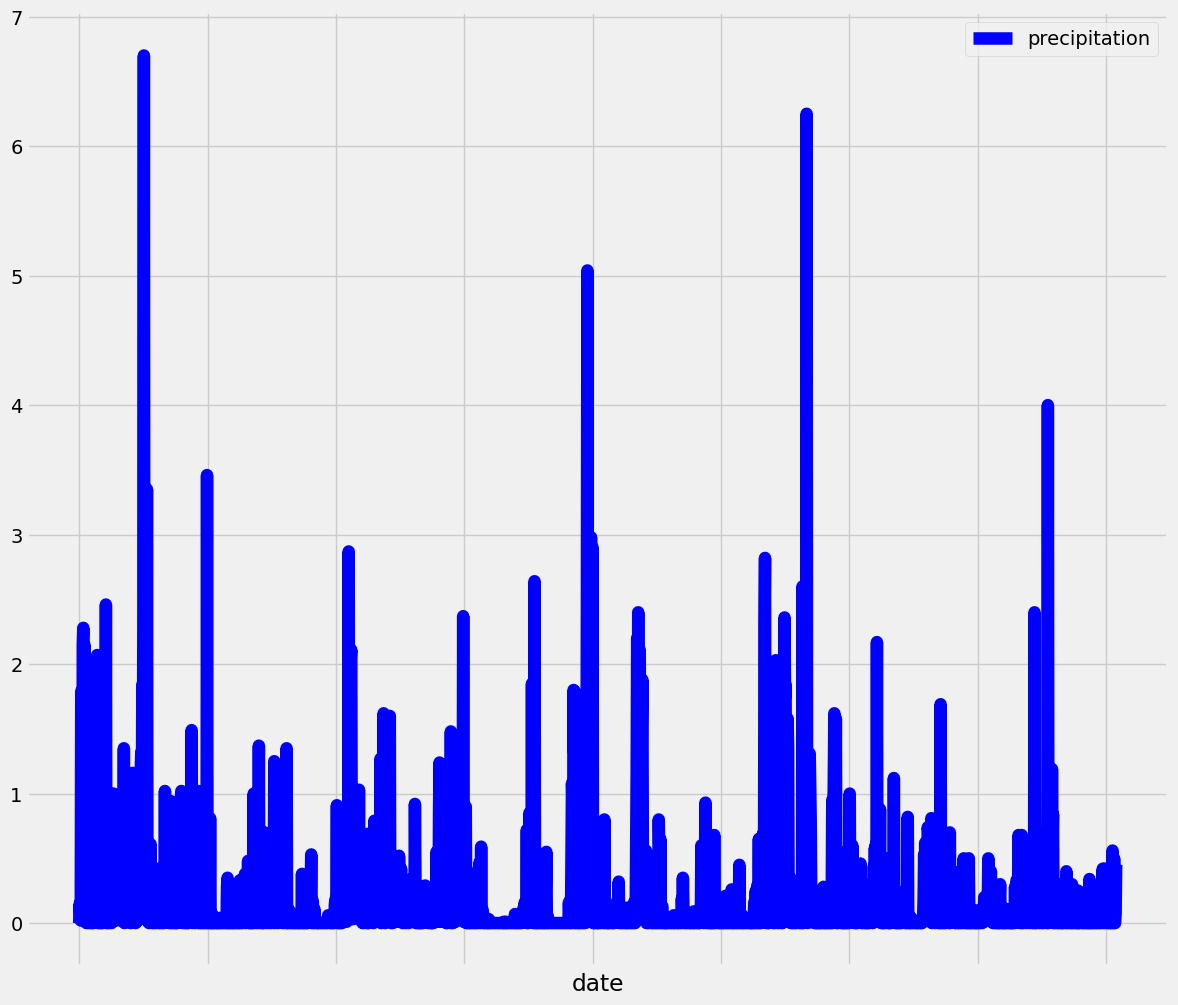

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
results_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results=session.query(measurement.date, measurement.prcp).order_by(measurement.date.asc()).\
        filter(measurement.date>=year_back).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax=df_results.plot(color='b',figsize=(12,10),legend=True,linewidth=9.0, grid= True)
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
station_count= session.query(func.count(station.id)).all()
station_count

[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_measure_join= session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
station_measure_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp= session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
              filter(measurement.station==station_measure_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

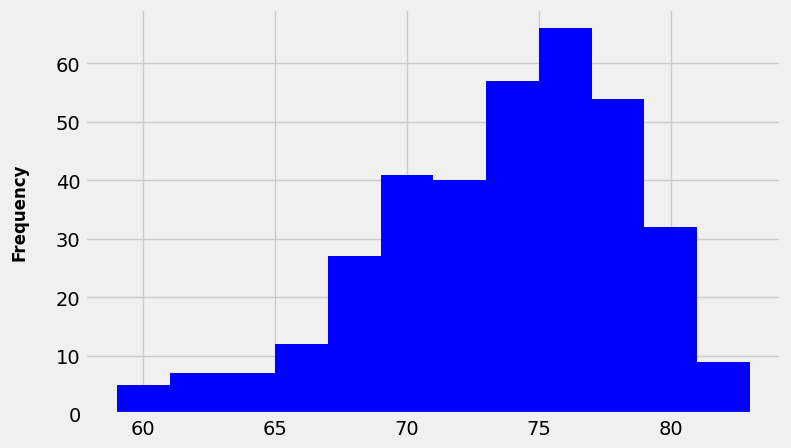

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date= session.query(measurement.date).order_by(measurement.date.desc()).\
            filter(measurement.station==station_measure_join[0][0]).first()
str_date= list(np.ravel(results_date))[0]
latest_date= dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back= latest_date-dt.timedelta(days=366)

results_temp=session.query(measurement.tobs).\
             filter(measurement.station==station_measure_join[0][0]).\
             filter(measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)

#Plotting 
hist= df_results['tobs'].hist(bins=12, figsize=(8,5), color= 'b', zorder= 2)

hist.set_ylabel('Frequency', labelpad= 20, weight= 'bold', size=12)

plt.show()


# Close Session

In [37]:
# Close Session
session.close()